The CIFAR-10 dataset: download and pre-processing
============================

The CIFAR-10 dataset can be downloaded at [www.cs.toronto.edu/~kriz/cifar.html](https://www.cs.toronto.edu/~kriz/cifar.html) and it is a single compressed file containing serialized numpy arrays:

- [cifar-10-python.tar.gz](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz): test and training sets (163 MB)

The archive contains the files *data_batch_1*, *data_batch_2*, ..., *data_batch_5*, as well as *test_batch*. Each of these files is a Python "pickled" object produced with cPickle. The pickle files can be easilly deserialized using the following function:

In [2]:
def unpickle(file):
    import cPickle
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict


The unpickle() method reuturns a dictionary of elements. Using the method on the file the *batches.meta* we get:

**label_names**: a 10 element list which gives meaningful names to the numeric labels in the labels array described above. For example, label_names[0] == "airplane", label_names[1] == "automobile", etc.

In [105]:
my_dict = unpickle("./batches.meta")
labels_names = my_dict["label_names"]
print labels_names

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


The various *data_batch_x* files contain the following arrays:

**data**: numpy array (shape: 10000x3072) of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.

**labels**: list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.

To continue this tutorial you need to open the CIFAR-10 archive, extract the file *data_batch_1* and copy it into the same folder of this notebook. Once you did this you can proceed with the next step:

In [112]:
my_dict = unpickle("./data_batch_1")
for key, value in my_dict.items() :
    print (key)

data
labels
batch_label
filenames


Pre-processing in Numpy
----------------------------

Using **numpy** and **matplotlib** it is possible to pick a random image from the training set and show it. In this example I will take the RGB channels and I will reshape and stack them, then through matplotlib I will display the resulting image:

bird


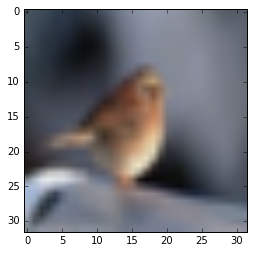

In [119]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

training_set = my_dict["data"]
random_int = np.random.randint(0,10000)
image_array = training_set[random_int]
image_R = np.reshape(image_array[0:1024], (32,32))
image_G = np.reshape(image_array[1024:2048], (32,32))
image_B = np.reshape(image_array[2048:4096], (32,32))
image = np.dstack((image_R, image_G, image_B))

label = my_dict["labels"][random_int]
label_name = labels_names[label]

print label_name
plt.imshow(image)
plt.show()

Pre-processing in Tensorflow
---------------------------------

In **tensorflow** we can easily manage the dataset. If all of your input data fit in memory(like in this case), the simplest way to create a dataset from them is to convert them to `tf.Tensor` objects and use `Dataset.from_tensor_slices()`. A `tf.data.Dataset` represents a sequence of elements, in which each element contains one or more Tensor objects. For example, in an image-based pipeline, an element might be a single training example, with a pair of tensors representing the image and a label.

In [89]:
import tensorflow as tf

tf_dataset = tf.data.Dataset.from_tensor_slices((my_dict["data"], my_dict["labels"]))

Using tensorflow it is also possible to apply a **map function** to the dataset. The map function allows us to sequentially reshape the images and to create one-hot-vector target from a single integer label. The map iterates all the elements stored into the dataset, and uses an external function to parse the data.

In [90]:
def _parse_function(image_array, label):
  label = tf.cast(label, tf.int32)
  image_R = tf.reshape(image_array[0:1024], [32, 32])
  image_G = tf.reshape(image_array[1024:2048], [32, 32])
  image_B = tf.reshape(image_array[2048:4096], [32, 32])
  image = tf.stack([image_R, image_G, image_B], axis=2)
  label_one_hot = tf.one_hot(label, depth=10)
  return image, label_one_hot

tf_dataset = tf_dataset.map(_parse_function) #parsing all the elements
tf_dataset = tf_dataset.shuffle(10000) #shuffling all the elements
print(tf_dataset.output_types)
print(tf_dataset.output_shapes)

(tf.uint8, tf.float32)
(TensorShape([Dimension(32), Dimension(32), Dimension(3)]), TensorShape([Dimension(10)]))


Once you have built a `Dataset` to represent your input data, the next step is to create an `Iterator` to access elements from that dataset. The `tf.data` API currently supports the following iterators, in increasing level of sophistication:

- one-shot
- initializable
- reinitializable
- feedable

A **one-shot** iterator is the simplest form of iterator, which only supports iterating once through a dataset, with no need for explicit initialization. One-shot iterators handle almost all of the cases that the existing queue-based input pipelines support. I can be initialized using the method `make_one_shot_iterator()`. The iterator can be combined with the `batch()` method in order to get a **batch** of elements that we can use to feed the model:

In [98]:

batch_size = 32
tf_batch = tf_dataset.batch(batch_size)
print(tf_batch.output_types)
print(tf_batch.output_shapes)

#the iterator is created, it will take batch_size elements from the dataset
iterator = tf_batch.make_one_shot_iterator()
#every time next_element is called batch_size new elements are taken
next_element = iterator.get_next()

with tf.Session() as sess:
    #print(sess.run(next_element))
    #print(sess.run(next_element))
    features, labels = sess.run(next_element) #this is how you can get the features and labels back

(tf.uint8, tf.float32)
(TensorShape([Dimension(None), Dimension(32), Dimension(32), Dimension(3)]), TensorShape([Dimension(None), Dimension(10)]))


Just o be sure we did not mess up with the dataset after all the previous operation, we can display a random image taken from the batch and check if it is corrupted. We can also print the associated label to see if it matches:

deer


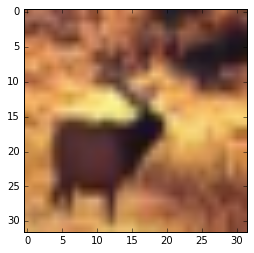

In [122]:
random_int = np.random.randint(batch_size)
image = features[random_int,:,:,:]
label = np.argmax(labels[random_int])
label_name = labels_names[label]
print label_name
plt.imshow(image)
plt.show()    

Complete pipeline in Tensorflow
-------------------------------------

Now it is time to stich everything togheter and create a tensorflow pipeline to load the entire CIFAR-10 dataset and use it for training a model.